In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns

np.random.seed(42)
pm.__version__

'5.16.2'

In [2]:
penguins = pd.read_csv("data/penguins.csv")
# удалим пропущенные данные
penguins = penguins.dropna(axis=0)
penguins.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009
343,Chinstrap,Dream,50.2,18.7,198.0,3775.0,female,2009


## Логистическая регрессия

Задачи регрессии относятся к прогнозированию непрерывного значения для выходной переменной на основе значений одной или нескольких входных переменных. 

В противоположность этому классификация занимается присваиванием дискретного значения (представляющего дискретный класс) выходной переменной на основе значений некоторых входных переменных. 

В обоих случаях задача состоит в том, чтобы получить модель, которая правильно формирует отображение соответствий между входными и выходными переменными. Чтобы добиться этого, необходимо иметь в своем распоряжении выборку с корректно определенными парами входных/выходных переменных. 

С точки зрения машинного обучения регрессии и классификации являются экземплярами алгоритмов обучения с учителем.

Модель логистической регрессии – это обобщение модели линейной регрессии для задач классификации, отсюда такое название. Такое обобщение производится посредством замены функции $f$  на логистическую функцию как функцию обратной связи:
$$ logistic(z) = \cfrac{1}{1+e^{-z}} $$

Для достижения нашей цели главным свойством этой логистической функции является то, что она фактически независима от значений ее аргумента $z$, поэтому результатом всегда будет число в интервале $[0,1]$. Таким образом, эту функцию можно рассматривать как удобный способ сжатия или упаковки значений, вычисляемых с помощью линейной модели, в диапазон значений, которые можно передать в распределение Бернулли. Эта логистическая функция также известна под названием сигмоидальная функция или просто сигма-функция, поскольку обладает характерной S-образной формой.

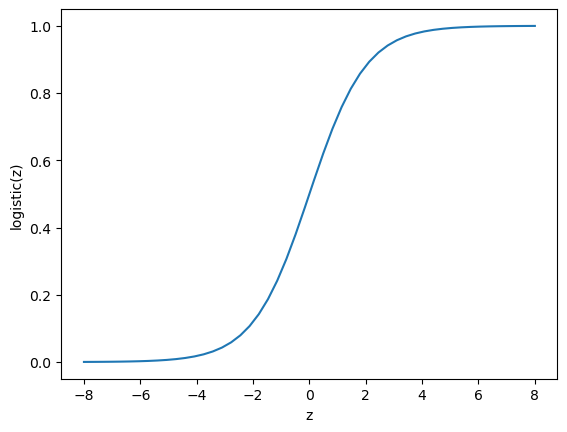

In [4]:
z = np.linspace(-8, 8) 
plt.plot(z, 1 / (1 + np.exp(-z))); 
plt.xlabel('z');
plt.ylabel('logistic(z)');

С помощью логистической регрессии мы можем использовать линейные модели для оценки вероятностей события. Однако часто необходимо классифицировать или предсказать определенный класс, учитывая наблюденные данные. 

Для этого мы хотим перевести непрерывное предсказание в интервале $(-\infty,+\infty)$ в интервал
 от 0 до 1 и назначить границу принятия решения ниже которой будем соотносить результат с 0, а выше границы с 1. Для модели с с одной объясняющей переменной можно записать:
$$
\begin{split}
0.5 &= logistic(\beta_{0} + \beta_{1} x) \\ 
logit(0.5) &= \beta_{0} + \beta_{1} x \\ 
0 &= \beta_{0} + \beta_{1} x \\ 
x &= -\frac{\beta_{0}}{\beta_{1}} \\ 
\end{split}
$$

Обратите внимание, что $logit(x) = \ln\left(\frac{x}{1-x}\right)$
и $logit^{-1}(x) = logistic(x)$, то есть, как только логистическая модель будет определена, мы можем использовать коэффициенты $\beta_{0}$ и $\beta_{1}$ для вычисления значения $x$, для определения вероятности принадлежности к классу.

## Задача классификации Пингвинов

В предыдущих разделах мы использовали пол и длину клюва пингвина для оценки массы пингвина. Давайте теперь поставим вопрос следующим образом: если бы нам дали массу, пол и длину пингвина, можем ли мы предсказать вид? 
Давайте используем два вида Adelie и Chinstrap, чтобы сделать это задачей бинарной классификации. Как и в прошлый раз, мы сначала используем простую модель только с одной объяснющей переменной, длиной клюва. 

Проблема с нецентрированными данными

In [8]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_non_center:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # логистическая регрессия
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # правдоподобие
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)
    
    # построение границы принятия решения
    bd = pm.Deterministic("bd", -β_0/β_1)

    

    idata_model_non_center = pm.sample(draws = 5000, chains=4, cores=4,
                                                    idata_kwargs={"log_likelihood":True},
                                                   )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
There were 10000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,-17.030,17.623,-39.619,0.875,8.679,6.632,5.0,150.0,2.29
β_1,0.821,0.087,0.614,0.926,0.025,0.018,12.0,145.0,1.57


/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


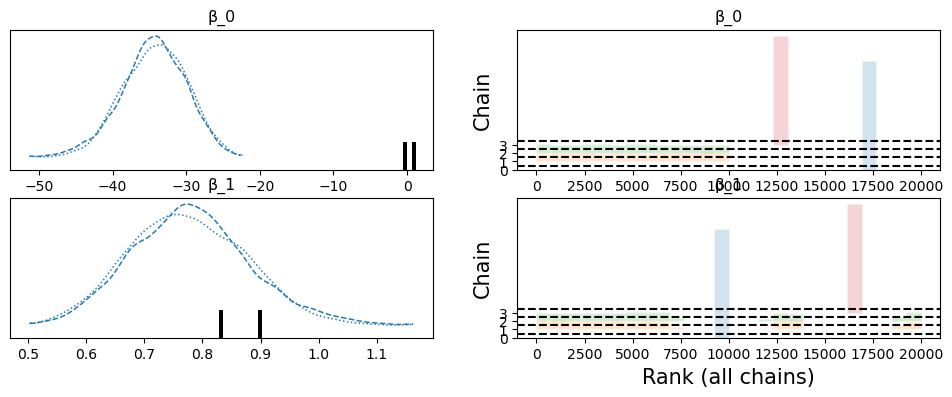

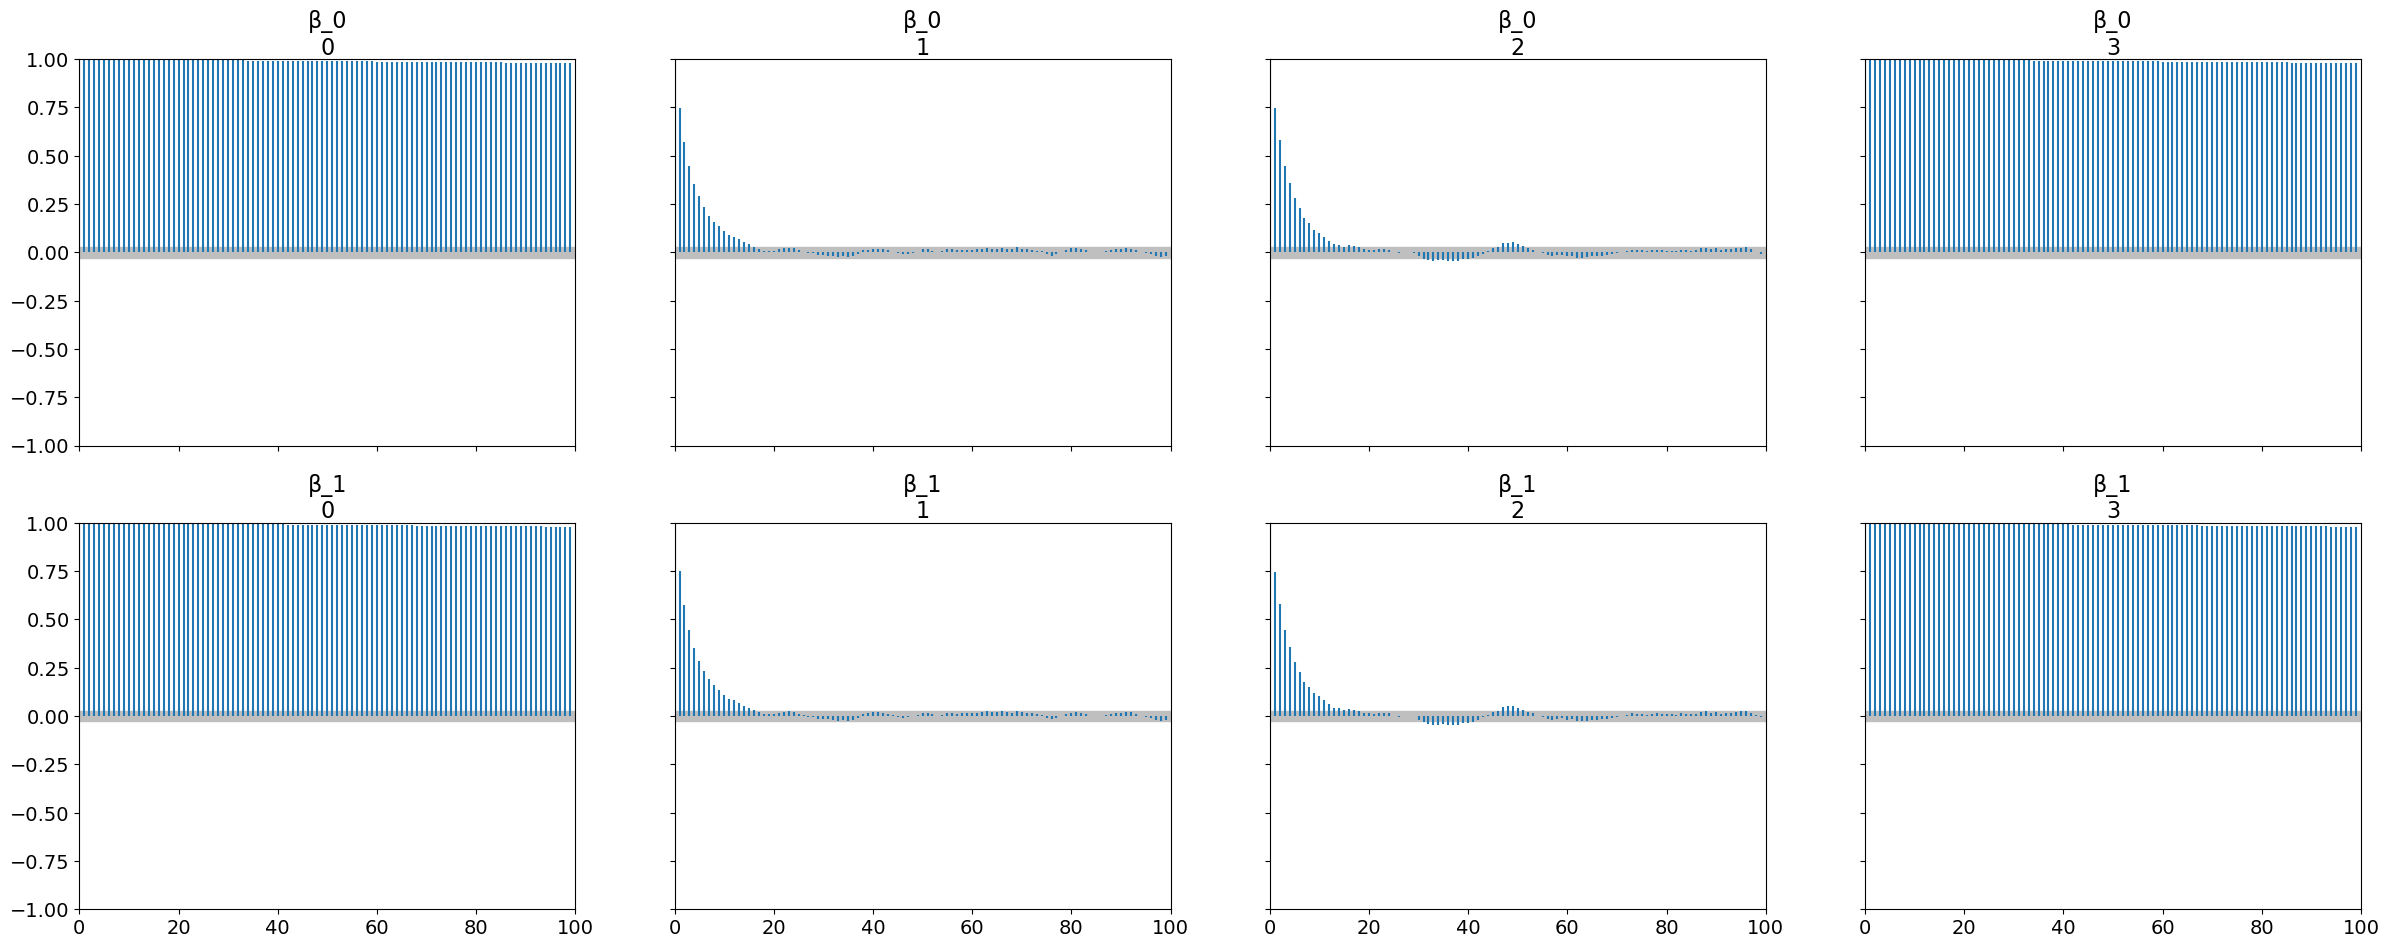

In [9]:
display(az.summary(idata_model_non_center, var_names=["β_0", "β_1"]))
az.plot_trace(idata_model_non_center, var_names=["β_0", "β_1"], kind="rank_bars");
az.plot_autocorr(idata_model_non_center, ["β_0", "β_1"]);

In [10]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
bill_length_obs_center = bill_length_obs - bill_length_obs.mean()
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0_tmp = pm.Normal("β_0_center", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0_tmp + pm.math.dot(bill_length_obs_center, β_1)

    # логистическая регрессия
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # правдоподобие
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)
    
    # построение границы принятия решения
    β_0 = pm.Deterministic('β_0', β_0_tmp - β_1 * bill_length_obs.mean())
    bd = pm.Deterministic("bd", -β_0/β_1)

    

    idata_logistic_penguins_bill_length = pm.sample(tune= 1000, draws = 5000, chains=4, cores=4,
                                                    idata_kwargs={"log_likelihood":True},
                                                   target_accept=0.95)

    # добавление априорных вероятностей
    idata_logistic_penguins_bill_length.extend(pm.sample_prior_predictive(samples=10000))
    # добавление апостериорных вероятностей
    idata_logistic_penguins_bill_length.extend(pm.sample_posterior_predictive(idata_logistic_penguins_bill_length))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0_center, β_1]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.
Sampling: [yl, β_0_center, β_1]
Sampling: [yl]


Output()

Количество предсказанных классов:

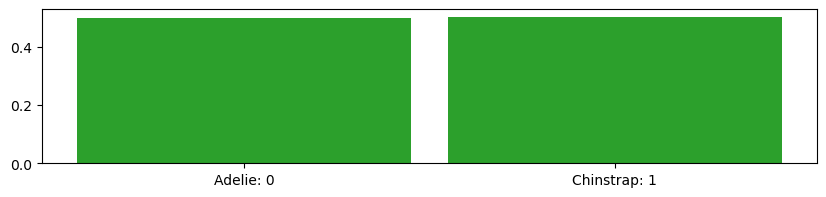

In [12]:
_, ax = plt.subplots(figsize=(10, 2))
az.plot_dist(idata_logistic_penguins_bill_length.prior_predictive["yl"], color="C2", ax=ax)
ax.set_xticklabels(["Adelie: 0", "Chinstrap: 1"] );

После подбора параметров в нашей модели мы можем проверить коэффициенты с помощью функции `az.summary()`. Полученные коэффициенты не поддаются такой прямой интерпретации, как в линейной регрессии, однако можем заметить, что существует некоторая взаимосвязь с длиной клюва и видом пингвина. 

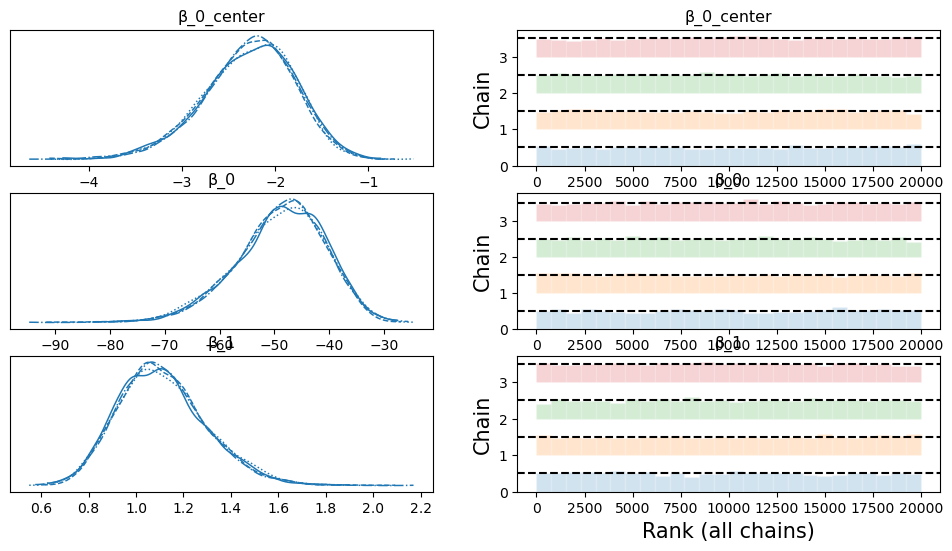

In [14]:
az.plot_trace(idata_logistic_penguins_bill_length, var_names=["β_0_center", "β_0", "β_1"], kind="rank_bars");

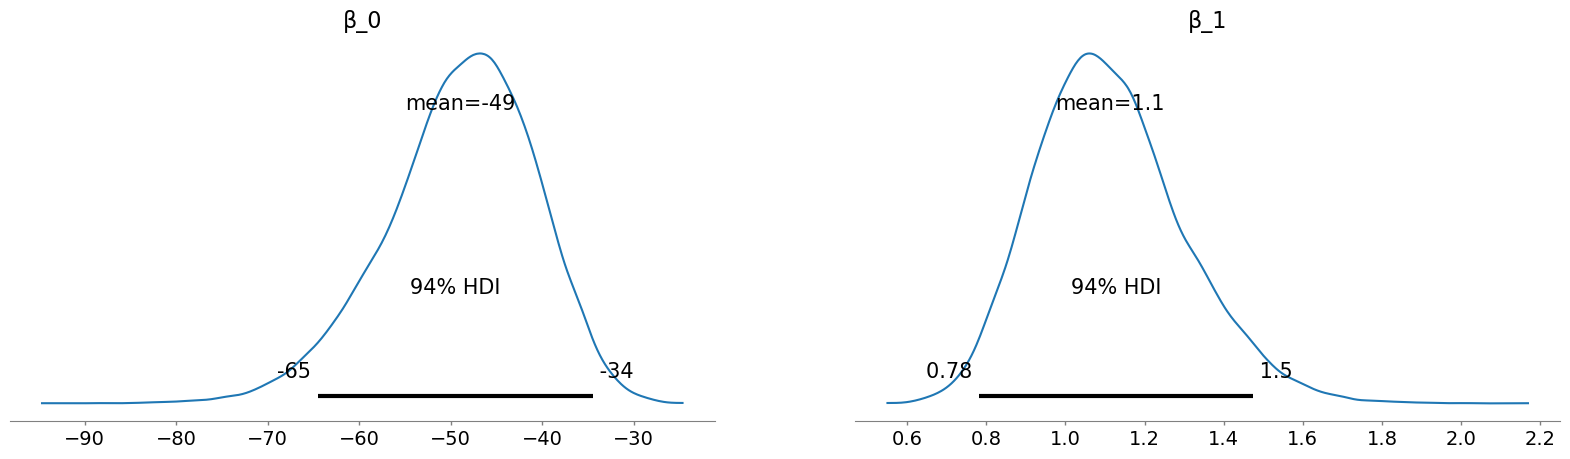

In [15]:
axes = az.plot_posterior(idata_logistic_penguins_bill_length, var_names = ["β_0", "β_1"], figsize=(20, 5));

In [16]:
az.summary(idata_logistic_penguins_bill_length, var_names=["β_0_center", "β_0", "β_1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0_center,-2.283,0.493,-3.236,-1.405,0.006,0.004,7941.0,8734.0,1.0
β_0,-48.968,8.169,-64.539,-34.451,0.101,0.073,6760.0,8249.0,1.0
β_1,1.111,0.187,0.783,1.473,0.002,0.002,6900.0,8302.0,1.0


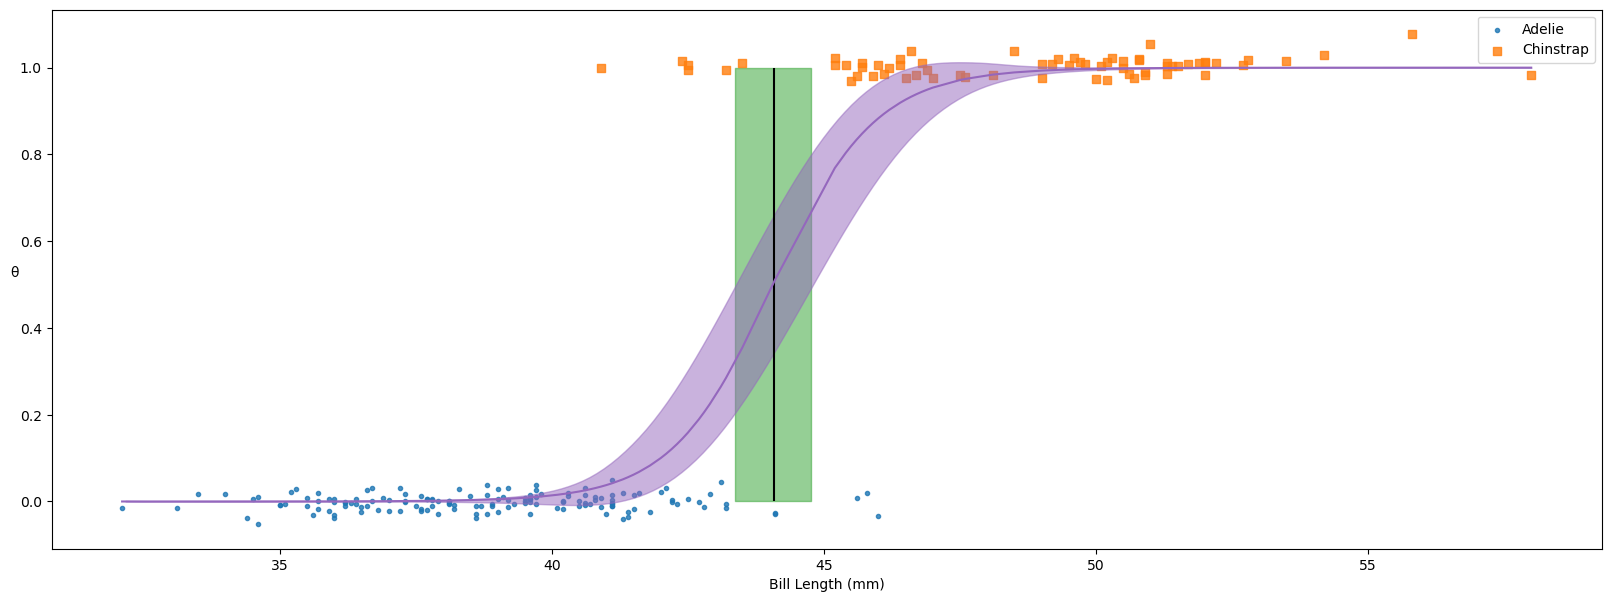

In [17]:
fig, ax = plt.subplots(figsize=(20, 7))

theta = idata_logistic_penguins_bill_length.posterior["θ"].mean(("chain", "draw"))
idx = np.argsort(bill_length_obs)

# Decision Boundary
ax.vlines(idata_logistic_penguins_bill_length.posterior["bd"].values.mean(), 0, 1, color='k')
bd_hpd = az.hdi(idata_logistic_penguins_bill_length.posterior["bd"].values.flatten(), ax=ax)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)


for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = bill_length_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(bill_length_obs, idata_logistic_penguins_bill_length.posterior["θ"].values, color='C4', ax=ax, plot_kwargs={"zorder":10})
ax.plot(bill_length_obs[idx], theta[idx], color='C4', zorder=10)

ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel('θ', rotation=0)
plt.legend();

Учитывая положительный коэффициент $\beta_1$, чей HDI больше нуля, можно довольно точно 
интерпретировать границу решения, учитывая, что длина клюва составляет около 44 мм и является номинальной границей между одним видом и другим. 

Построение результатов регрессии гораздо более интуитивно понятно. Здесь же мы видим, что логистическая кривая изменяется от 0 слева к 1 справа по мере изменения классов и границы принятия решений.

Давайте попробуем что-то другое, будем классифицировать пингвинов, используя массу в качестве объясняющей переменной.

In [20]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
mass_obs = penguins.loc[species_filter, "body_mass_g"].values
mass_obs_center = mass_obs - mass_obs.mean()

with pm.Model() as model_logistic_penguins_mass:
    β_0_tmp = pm.Normal("β_0_center", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0_tmp + pm.math.dot(mass_obs_center, β_1)

    # логистическая регрессия
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # правдоподобие
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)
    
    # построение границы принятия решения
    β_0 = pm.Deterministic('β_0', β_0_tmp - β_1 * mass_obs.mean())
    bd = pm.Deterministic("bd", -β_0/β_1)

    idata_logistic_penguins_mass = pm.sample(5000, chains=2, cores=4,
                                            random_seed=1,  
                                             target_accept=.95, 
                                             idata_kwargs={"log_likelihood":True})
    
    idata_logistic_penguins_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_mass))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_0_center, β_1]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 10000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [yl]


Output()

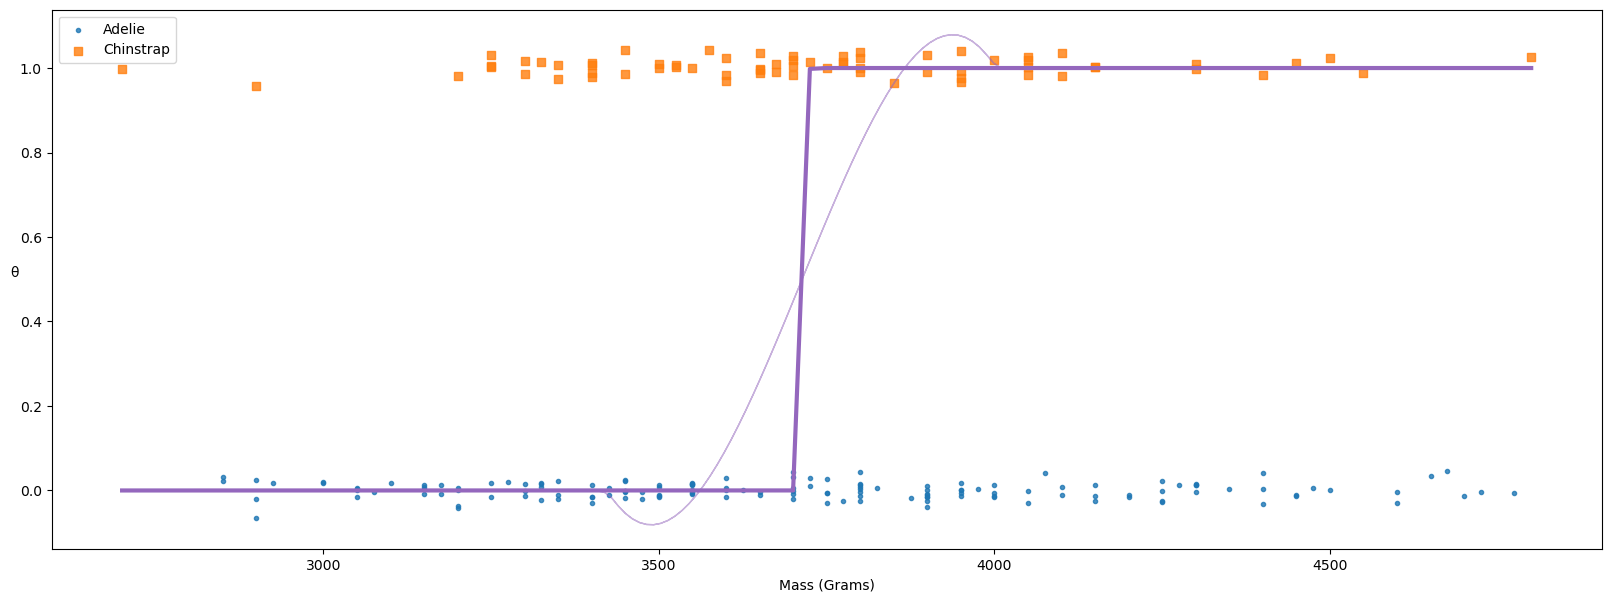

In [21]:
theta = idata_logistic_penguins_mass.posterior['θ'].mean(("chain", "draw"))
bd = idata_logistic_penguins_mass.posterior['bd']

fig, ax = plt.subplots(figsize=(20, 7))
idx = np.argsort(mass_obs)

ax.plot(mass_obs[idx], theta[idx], color='C4', lw=3)
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = mass_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(mass_obs[_filter], y, marker=marker, label=label, alpha=.8)



az.plot_hdi(mass_obs, idata_logistic_penguins_mass.posterior['θ'], color='C4', ax=ax)

ax.set_xlabel("Mass (Grams)")
ax.set_ylabel('θ', rotation=0)
plt.legend();


Очевидно, что результат моделирования неудачен, но это не всегда плохо. В данном случае это говорит о том, что недостаточно знать только вес пингвина для построения удачной модели. Любое построение качественной модели лежит через череду проб и ошибок ...

Давайте попробуем построить множественную логистическую регрессию и посмотрим , что у нас получится.

Модель без центрирования

In [25]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
species = pd.Categorical(penguins.loc[species_filter, "species"])
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# добавим колонку с 1 для свободной переменной
X.insert(0,"Intercept", value=1)
X = X.values
X[:,2] = X[:,2]/100

with pm.Model() as model_non_center_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)
    μ = pm.math.dot(X, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X[:,1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_non_center_bill_length_mass = pm.sample(5000, chains=4,
                                                         random_seed=0, 
                                                         target_accept=.9,
                                                         idata_kwargs={"log_likelihood":True})
    idata_non_center_bill_length_mass.extend(pm.sample_posterior_predictive(idata_non_center_bill_length_mass))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 14 seconds.
There were 2094 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [yl]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],-44.959,8.325,-60.651,-30.020,0.137,0.098,3688.0,4120.0,1.0
β[1],1.820,0.336,1.240,2.464,0.006,0.004,3172.0,3201.0,1.0
β[2],-0.940,0.238,-1.388,-0.503,0.004,0.003,3831.0,3326.0,1.0


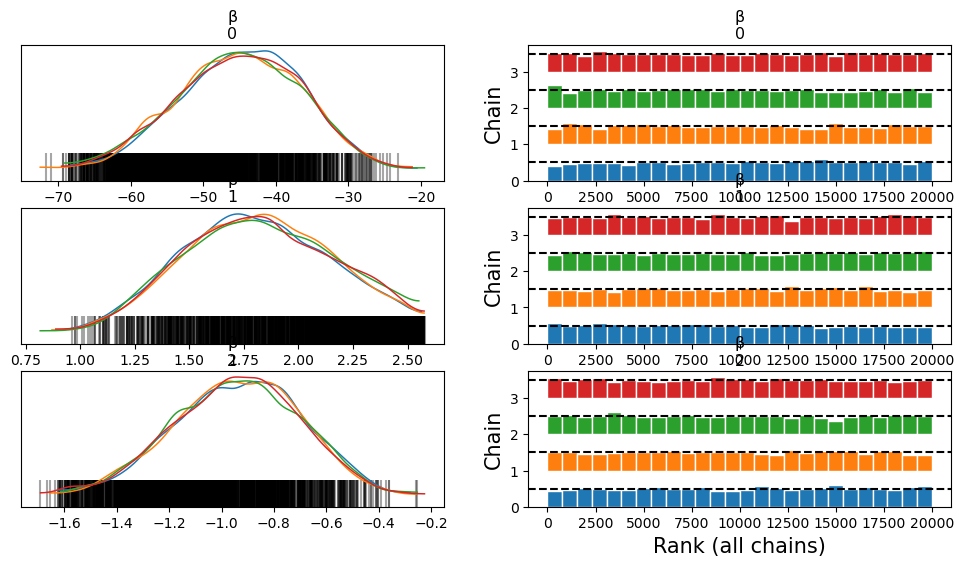

In [26]:
display(az.summary(idata_non_center_bill_length_mass,  var_names=["β"]))
az.plot_trace(idata_non_center_bill_length_mass,compact=False, var_names=["β"], kind="rank_bars");

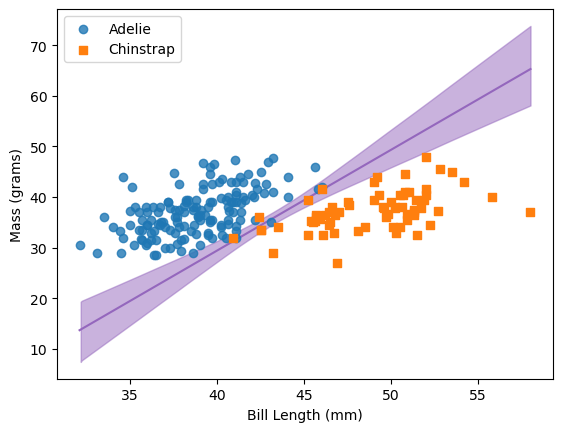

In [27]:
ig,ax  = plt.subplots()
idx = np.argsort(X[:,1])
bd = idata_non_center_bill_length_mass.posterior["bd"].mean(("chain", "draw"))[idx]


species_filter = species.codes.astype(bool)

# Linear fit
ax.plot(X[:,1][idx], bd, color='C4');
az.plot_hdi(X[:,1], idata_non_center_bill_length_mass.posterior["bd"], color='C4', ax=ax)

# Scatter
ax.scatter(X[~species_filter,1], X[~species_filter,2], alpha=.8,  
           label="Adelie", zorder=10)
ax.scatter(X[species_filter,1], X[species_filter,2], marker="s", 
           label="Chinstrap", zorder=10)


ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")


ax.legend();

Модель с центрированием

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.
There were 8435 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [yl]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],-3.763,0.816,-5.247,-2.216,0.019,0.015,1921.0,1599.0,1.0
β[1],2.095,0.326,1.502,2.599,0.007,0.005,1665.0,2020.0,1.0
β[2],-1.019,0.226,-1.424,-0.582,0.005,0.004,1744.0,1712.0,1.0


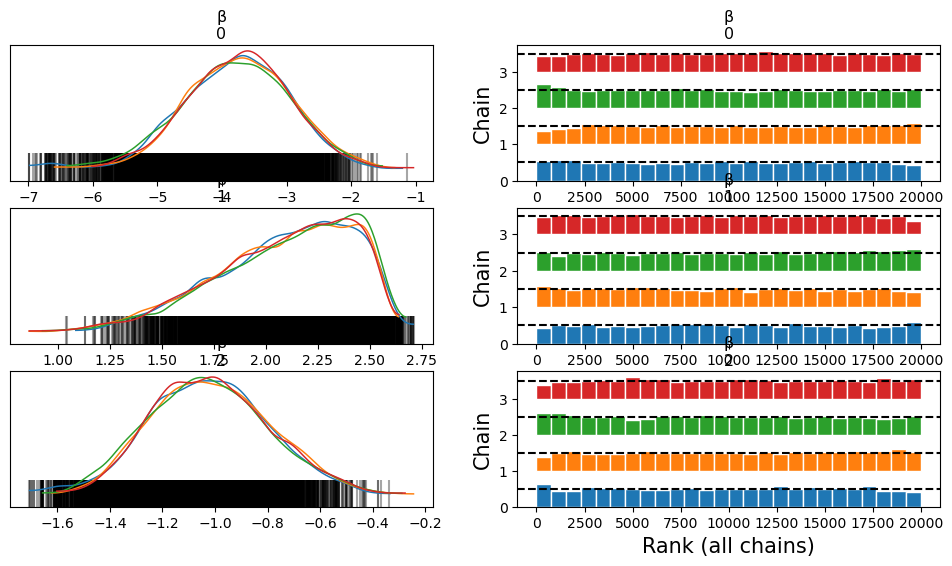

In [29]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
species = pd.Categorical(penguins.loc[species_filter, "species"])
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]#"flipper_length_mm"

X_means = X.mean(axis=0)
X_center = X - X_means
# добавим колонку с 1 для свободной переменной
X_center.insert(0,"Intercept", value=1)
X_center = X_center.values
X_center[:,2] = X_center[:,2]/100


with pm.Model() as model_logistic_penguins_bill_length_mass_c:
    β = pm.Normal("β", mu=0, sigma=5, shape=3)
    μ = pm.math.dot(X_center, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X_center[:,1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_bill_length_mass_c = pm.sample(5000, chains=4,
                                                         random_seed=0,
                                                         target_accept=.9,
                                                         idata_kwargs={"log_likelihood":True}
                                                         )
    idata_logistic_penguins_bill_length_mass_c.extend(
        pm.sample_posterior_predictive(idata_logistic_penguins_bill_length_mass_c))

display(az.summary(idata_logistic_penguins_bill_length_mass_c,  var_names=["β"]))
az.plot_trace(idata_logistic_penguins_bill_length_mass_c,compact=False, var_names=["β"], kind="rank_bars");

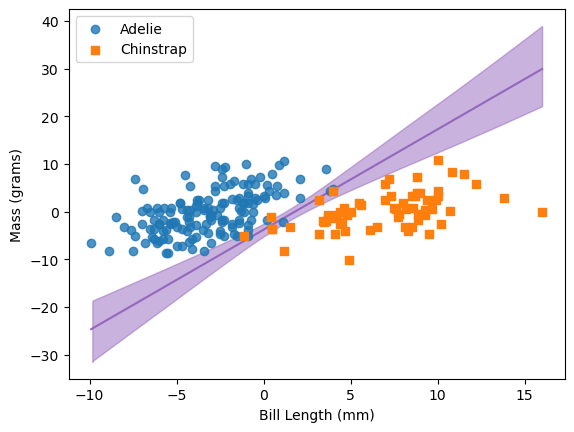

In [30]:
fig,ax  = plt.subplots()
idx = np.argsort(X_center[:,1])
bd = idata_logistic_penguins_bill_length_mass_c.posterior["bd"].mean(("chain", "draw"))[idx]
species_filter = species.codes.astype(bool)
# Linear fit
ax.plot(X_center[:,1][idx], bd, color='C4');
az.plot_hdi(X_center[:,1], idata_logistic_penguins_bill_length_mass_c.posterior["bd"], color='C4', ax=ax)
# Scatter
ax.scatter(X_center[~species_filter,1], X_center[~species_filter,2], alpha=.8,  
           label="Adelie", zorder=10)
ax.scatter(X_center[species_filter,1], X_center[species_filter,2], marker="s", 
           label="Chinstrap", zorder=10)
ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")
ax.legend();


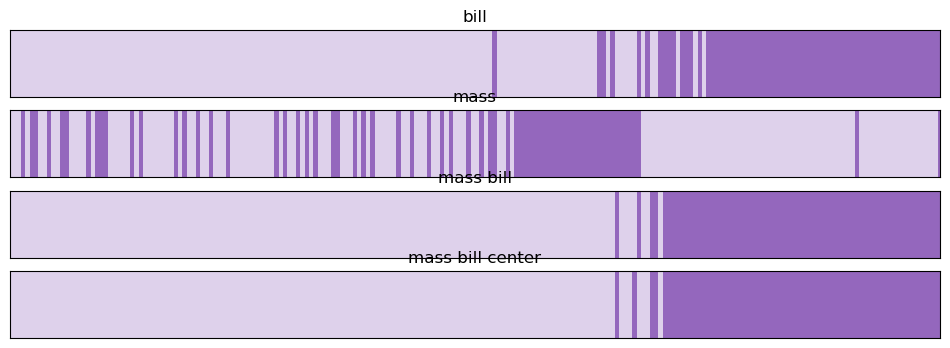

In [31]:
models = {"bill": idata_logistic_penguins_bill_length,
          "mass": idata_logistic_penguins_mass,
          "mass bill": idata_non_center_bill_length_mass,
          "mass bill center": idata_logistic_penguins_bill_length_mass_c,
         }


_, axes = plt.subplots(4, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)

In [32]:
compare_model = az.compare({"bill": idata_logistic_penguins_bill_length,
            "mass": idata_logistic_penguins_mass,
            "mass bill": idata_non_center_bill_length_mass,
            "mass bill center": idata_logistic_penguins_bill_length_mass_c,
           }).round(3)

/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:670: RuntimeWarning: invalid value encountered in scalar divide
  rho_hat_odd = 1.0 - (mean_var - np.mean(acov[:, 1])) / var_plus
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:670: RuntimeWarning: invalid value encountered in scalar divide
  rho_hat_odd = 1.0 - (mean_var - np.mean(acov[:, 1])) / var_plus
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:670: RuntimeWarning: invalid value encountered in scalar divide
  rho_hat_odd = 1.0 - (mean_var - np.mean(acov[:, 1])) / var_plus
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:670: RuntimeWarning: invalid value encountered in scalar divide
  rho_hat_odd = 1.0 - (mean_var - np.mean(acov[:, 1])) / var_plus
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater tha

### Информационные критерии

Информационные критерии – это набор различных, иногда взаимосвязанных инструментальных средств, которые используются для сравнения моделей в отношении того, насколько точно они соответствуют конкретным данным, при этом сложность моделей учитывается через штрафные факторы. 

Нам необходим надежный способ достижения баланса между степенью точности объяснения данных моделью, с одной стороны, и степенью сложности модели – с другой.

На данный момент самыми наиболее часто применимыми критериями являются:
* WAIC (widely applicable information criterion or Watanabe-Aikake information criterion) информационный критерий Ватанабе–Аикаке
* LOO (LOOCV) - Парето-сглаженная выборка по значимости для перекрестной проверки. При перекрестной проверке данные многократно разделяются на тренировочный и тестовый набор, итеративно подбирая модель и оценивая соответствие с тестовыми данными.

Мы не будем подробно останавливаться на данных критериях, однако отметич, что они "делают": 
* WAIC содержит два элемента: первый измеряет степень соответствия данных и модели, второй – штрафует сложные модели
* основная идея заключается в возможности аппроксимации LOOCV при помощи соответствующего перерасчета весовых коэффициентов правдоподоби. Проблема заключается в том, что результаты нестабильны. Для устранения нестабильности был введен новый метод с применением подхода, названного парето-сглаженной выборкой по значимости для перекрестной проверки LOOCV (Pareto-smoothed importance sampling – PSIS), который может применяться для вычисления более надежных оценок LOOCV.


Первый столбец - это индекс, в котором перечислены имена моделей, взятых из ключей словаря, 
переданных `az.compare()`
1. `rank` - ранг модели, лучшая имеет ранг 0
2. `elpd_loo` - содержит значения ELPD. Фрейм данных всегда сортируется от наилучшего значения ELPD к наихудшему.
3. `p_loo` - оценка эффективного количества параметров. Дает подсказку насколько модель гибка в подборе образца.
4. `elpd_diff` – относительная разность между значением `p_loo` для модели с наивысшей оценкой и значениями `p_loo` для каждой последующей модели. Поэтому для первой модели в этом столбце всегда находится значение 0.
5. `weight` - иногда при сравнении моделей не требуется выбирать самую лучшую модель. Вместо этого необходимы прогнозы по усредненным характеристикам всех моделей (или нескольких моделей). В идеальном варианте желательно получить взвешенное среднее арифметическое с приданием большего веса той модели, которая, как предполагается, лучше объясняет/прогнозирует данные. Эти весовые коэффициенты можно приблизительно интерпретировать как вероятность выбора каждой модели (из сравниваемых моделей) с учетом наблюдаемых данных.
6. `se` - значения стандартной ошибки при вычислениях `elpd_loo`. Стандартная ошибка может оказаться полезной для установления неопределенности оценок `elpd_loo`.
7. `dse` - стандартая ошибкa разностей между двумя значениями `elpd_loo`. Для модели с наивысшей оценкой это значение всегда равно 0.
8. `waring` - значение True сообщает, что вычисление `elpd_loo`, возможно, является ненадежным.
9. `scale` - масштаб (тип) отображения `elpd_loo`. Варианты - log : (по умолчанию) логарифмический; negative_log : -1 * логарифмический; deviance : -2 * логарифмический.

In [34]:
compare_model

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mass bill center,0,-10.970,1.836,0.000,1.0,3.276,0.000,True,log
mass bill,1,-11.267,1.526,0.296,0.0,3.055,0.517,True,log
bill,2,-27.309,2.078,16.339,0.0,6.581,4.961,False,log
mass,3,-32322.364,11738.058,32311.393,0.0,3379.049,3378.980,True,log


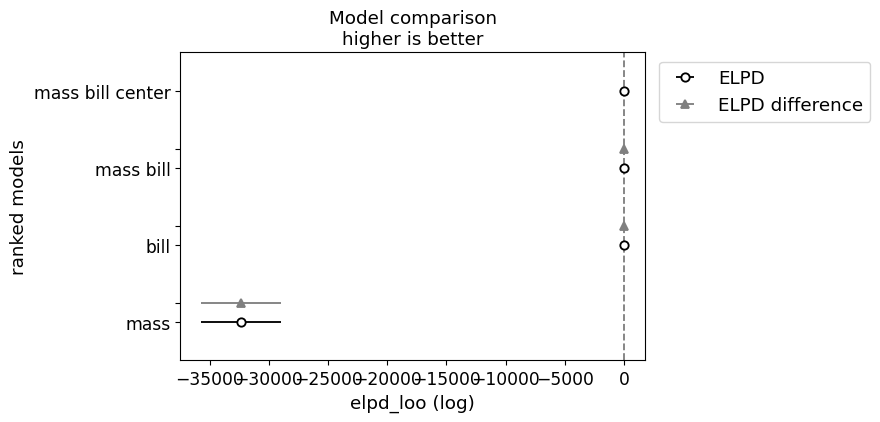

In [35]:
az.plot_compare(compare_model);

/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1039: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO post

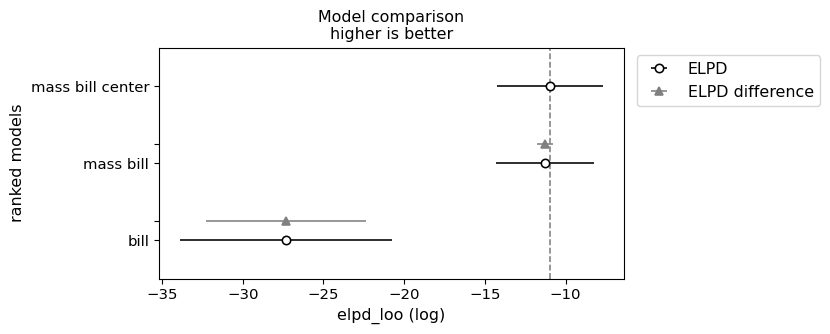

In [36]:
compare_model_minus = az.compare({"bill": idata_logistic_penguins_bill_length,
            "mass bill": idata_non_center_bill_length_mass,
            "mass bill center": idata_logistic_penguins_bill_length_mass_c,
           }).round(3)
az.plot_compare(compare_model_minus);

### Борьба с выбросами (робастные модели логистической регрессии)
Рассотрим методику корректировку выбросов без прямого моделирования фактора, порождающего эту проблему. 

Данная методика, может
применяться для выполнения более надежной (робастной) версии логистической регрессии. Напомним, что при использовании логистической регрессии мы моделируем данные как биномиальные, то есть нули и единицы. Поэтому может возникнуть ситуация, когда в наборе данных обнаружатся ненужные нули и/или единицы (из-за погрешностей наблюдений, выброcов).

Можно сказать, что значение выходной переменной получается с вероятностью $\pi$ при случайном угадывании (предсказании) или с вероятностью $1 – \pi$ из модели логистической регрессии. 

Запишем, что:
$$p = \pi 0.5 + (1 – \pi)logistic(\alpha + X\beta)$$

Заметим, что при $\pi = 1$ получаем $p = 0.5$, а при $\pi = 0$ возвращаемся к формуле логистической регрессии. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, π]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
Sampling: [yl]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],-5.176,1.632,-8.237,-2.439,0.028,0.021,3647.0,4727.0,1.0
β[1],3.011,0.938,1.437,4.698,0.016,0.012,3574.0,4397.0,1.0
β[2],-1.500,0.519,-2.465,-0.624,0.009,0.007,3580.0,4617.0,1.0


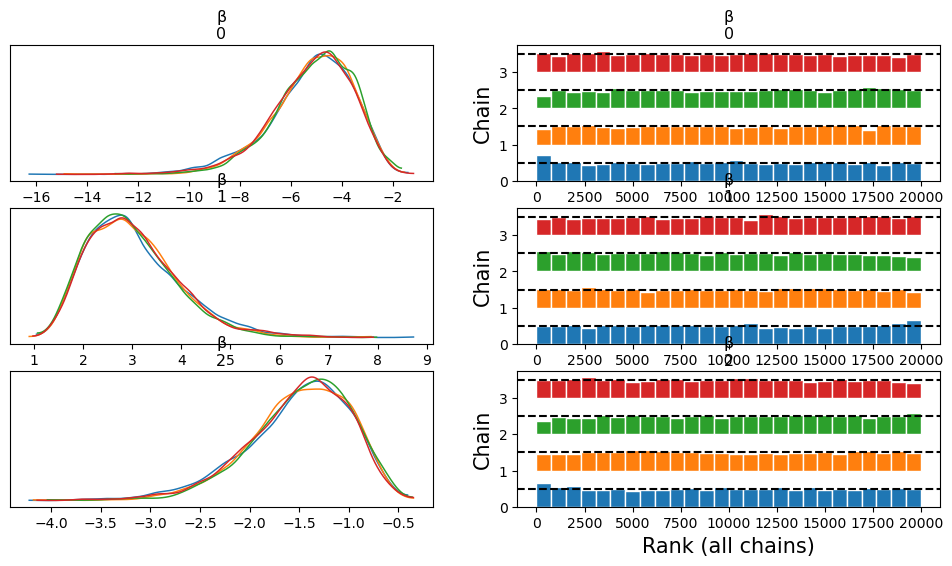

In [38]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
species = pd.Categorical(penguins.loc[species_filter, "species"])
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]#"flipper_length_mm"

X_means = X.mean(axis=0)
X_center = X - X_means
# добавим колонку с 1 для свободной переменной
X_center.insert(0,"Intercept", value=1)
X_center = X_center.values
X_center[:,2] = X_center[:,2]/100


with pm.Model() as model_robust:
    β = pm.Normal("β", mu=0, sigma=5, shape=3)
    μ = pm.math.dot(X_center, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    
    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ
    
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X_center[:,1])

    yl = pm.Bernoulli("yl", p=p, observed=species.codes)  # ВНИМАНИЕ p=p, а не правдоподобию !
    

    idata_model_robust = pm.sample(5000, chains=4,
                                                         
                                                         target_accept=.9,
                                                         idata_kwargs={"log_likelihood":True}
                                                         )
    idata_model_robust.extend(
        pm.sample_posterior_predictive(idata_model_robust))


display(az.summary(idata_model_robust,  var_names=["β"]))
az.plot_trace(idata_model_robust,compact=False, var_names=["β"], kind="rank_bars");

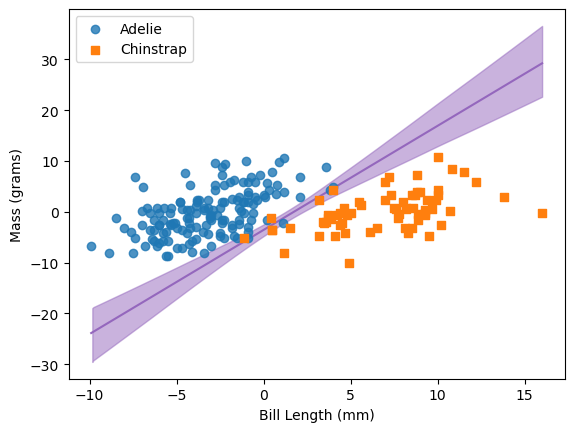

In [39]:
fig,ax  = plt.subplots()
idx = np.argsort(X_center[:,1])
bd = idata_model_robust.posterior["bd"].mean(("chain", "draw"))[idx]
species_filter = species.codes.astype(bool)
# Linear fit
ax.plot(X_center[:,1][idx], bd, color='C4');
az.plot_hdi(X_center[:,1], idata_model_robust.posterior["bd"], color='C4', ax=ax)
# Scatter
ax.scatter(X_center[~species_filter,1], X_center[~species_filter,2], alpha=.8,  
           label="Adelie", zorder=10)
ax.scatter(X_center[species_filter,1], X_center[species_filter,2], marker="s", 
           label="Chinstrap", zorder=10)
ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")
ax.legend();

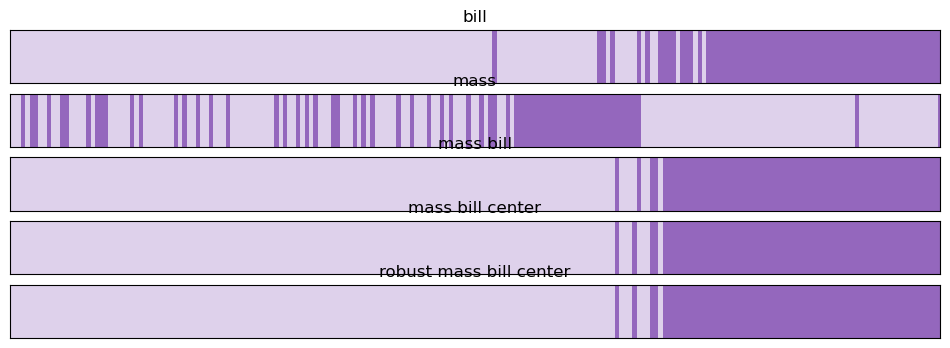

In [40]:
models = {"bill": idata_logistic_penguins_bill_length,
          "mass": idata_logistic_penguins_mass,
          "mass bill": idata_non_center_bill_length_mass,
          "mass bill center": idata_logistic_penguins_bill_length_mass_c,
          "robust mass bill center": idata_model_robust
         }


_, axes = plt.subplots(5, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)

/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1039: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/macbook/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO post

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mass bill center,0,-10.970,1.836,0.000,1.0,3.276,0.000,True,log
mass bill,1,-11.267,1.526,0.296,0.0,3.055,0.517,True,log
robust mass bill center,2,-12.597,2.793,1.627,0.0,3.926,0.917,False,log
bill,3,-27.309,2.078,16.339,0.0,6.581,4.961,False,log


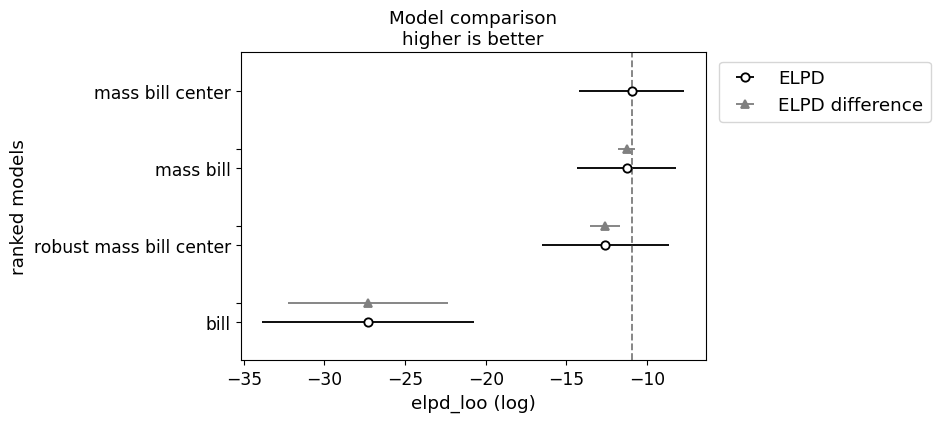

In [41]:
compare_model_robust = az.compare({"bill": idata_logistic_penguins_bill_length,
            "mass bill": idata_non_center_bill_length_mass,
            "mass bill center": idata_logistic_penguins_bill_length_mass_c,
            "robust mass bill center": idata_model_robust                      
           }).round(3)
display(compare_model_robust)
az.plot_compare(compare_model_robust);

## Регрессия с использованием функции softmax

Одним из способов обобщения логистической регрессии для более чем двух классов является регрессия с применением функции softmax. Необходимо внести два изменения по сравнению с логистической регрессией: 

* во-первых, заменить логистическую функцию на функцию softmax:
$$ softmax_i(\mu) = \dfrac{\exp(\mu_i)}{\sum_i \exp( \mu_i)} $$
Другими словами, для получения выходных данных функции softmax для $i$-го элемента вектора $\mu$ берется экспонента от значения $\mu_i$ и делится на сумму экспонент всех значений, содержащихся в векторе $\mu$. Функция softmax гарантирует получение положительных значений, которые в сумме дают 1. Эта функция представляет собой сокращенную версию логистической функции при $k = 2$.

* во-вторых, заменить распределения Бернулли на категориальное распределение. Категориальное распределение – это обобщение распределения Бернулли для получения более двух выходных результатов. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.
Sampling: [yl]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],-5.176,1.632,-8.237,-2.439,0.028,0.021,3647.0,4727.0,1.0
β[1],3.011,0.938,1.437,4.698,0.016,0.012,3574.0,4397.0,1.0
β[2],-1.500,0.519,-2.465,-0.624,0.009,0.007,3580.0,4617.0,1.0


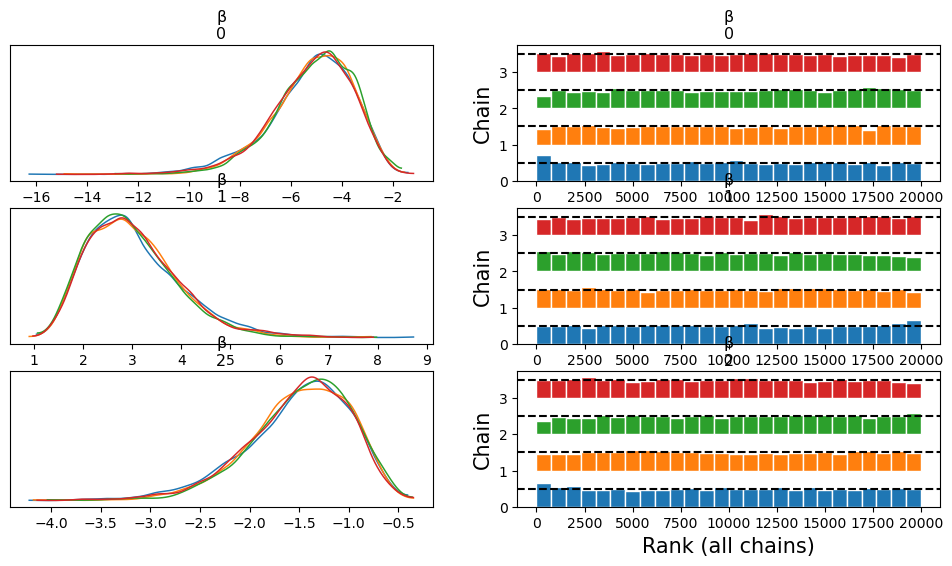

In [43]:

species = pd.Categorical(penguins["species"])
X = penguins[["bill_length_mm", "body_mass_g"]]#"flipper_length_mm"

X_means = X.mean(axis=0)
X_center = X - X_means
# добавим колонку с 1 для свободной переменной
X_center.insert(0,"Intercept", value=1)
X_center = X_center.values
X_center[:,2] = X_center[:,2]/100


with pm.Model() as model_soft:
    β = pm.Normal('β', mu=0, sigma=10, shape=(3,3))
    μ = pm.Deterministic('μ', pm.math.dot(X_center, β))
    θ = pm.Deterministic("θ", pm.math.softmax(μ, axis=1))
    
    yl = pm.Categorical("yl", p=θ, observed=species.codes)  
    
    idata_model_soft = pm.sample(2000, chains=4,
                                       target_accept=.9,
                                       idata_kwargs={"log_likelihood":True}
                                                         )
    idata_model_soft.extend(
        pm.sample_posterior_predictive(idata_model_soft))


display(az.summary(idata_model_robust,  var_names=["β"]))
az.plot_trace(idata_model_robust,compact=False, var_names=["β"], kind="rank_bars");

In [44]:
data = idata_model_soft.posterior['μ'].mean(("chain", "draw")).values
np.array([(np.exp(point)/np.sum(np.exp(point), axis=0)).round(3)
                                      for point in data])[:10]

array([[0.999, 0.   , 0.001],
       [0.999, 0.   , 0.001],
       [0.981, 0.019, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.999, 0.   , 0.001],
       [1.   , 0.   , 0.   ],
       [0.921, 0.   , 0.079],
       [0.501, 0.499, 0.   ],
       [0.999, 0.   , 0.001],
       [1.   , 0.   , 0.   ]])

## Порождающая модель

In [ ]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
species = pd.Categorical(penguins.loc[species_filter, "species"])
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

df = iris[iris['species'].isin(['setosa', 'versicolor'])]
y_0 = pd.Categorical(df['species']).codes
column = 'sepal_length'
x_0 = df[column].values

with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    setosa = pm.Normal('setosa', mu=μ[0], sigma=σ[0], observed=x_0[:50]) 
    versicolor = pm.Normal('versicolor', mu=μ[1], sigma=σ[1], observed=x_0[50:]) 
    
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)